In [1]:
!pip install pyTigerGraph

## Connect to a Synthea TigerGraph server


In [2]:
import getpass

server = 'https://yaniv.i.tgcloud.io'
password = getpass.getpass()

········


In [3]:
import pyTigerGraph as tg 

conn = tg.TigerGraphConnection(
    host=server, 
    graphname="synthea", 
    username="tigergraph",
    password=password,
)

shell = tg.Gsql(conn, client_version="2.6.0")

In [4]:
!ls -l $shell.jarLocation

total 1432
-rw-r--r--  1 ybenami  ybenami  671144 Jul 18 00:38 gsql_client.jar
-rw-r--r--  1 ybenami  ybenami    8518 Jun 26 09:04 my-cert.txt


In [5]:
#!rm -rf $shell.jarLocation

In [6]:
secret = shell.createSecret()
conn.getToken(secret=secret)

('q39d0d2a8t8bm7vbpkstab7uiv9m35us', 1597642725, '2020-08-17 05:38:45')

In [7]:
query = '''
drop query get_all_patients
create query get_all_patients() for graph synthea{
    TYPEDEF TUPLE <description STRING, date DATETIME> CondTup;

    BagAccum <CondTup> @conditions;

    patients = {Patient.*};

    patients = select pat from patients:pat;

    x = select pat from patients:pat-(PATIENT_HAS_CONDITION)-Condition:cond
            accum pat.@conditions += CondTup(cond.description, cond.startDate);

    print patients;
}
install query get_all_patients
'''

print(shell.gsql(query))

Trying version: v2_6_0
Connecting to yaniv.i.tgcloud.io:14240
If there is any relative path, it is relative to tigergraph/dev/gdk/gsql
The query get_all_patients is dropped.
The query get_all_patients has been added!
Start installing queries, about 1 minute ...
get_all_patients query: curl -X GET 'https://127.0.0.1:9000/query/synthea/get_all_patients'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.

[=================================================================] 100% (1/1) 



In [7]:
query = conn.runInstalledQuery('get_all_patients', sizeLimit=10**10)

In [8]:
len(query[0]['patients'])

109321

In [9]:
%%writefile getFeatures.py

import numpy as np
import pandas as pd
from datetime import datetime
import math

def yaniv_to_ed_query(query):

    query[0]['people'] = query[0].pop('patients')

    for patient in query[0]['people']:
        patient['attributes']['people.dateOfBirth'] = patient['attributes'].pop('birth')
        patient['attributes']['people.dateOfDeath'] = patient['attributes'].pop('death')
        patient['attributes']['people.@gender'] = [(
            'F' if patient['attributes'].pop('gender') == 'female'
            else 'M')]
        patient['attributes']['people.@diagData'] = patient['attributes'].pop('@conditions')
        for condition in patient['attributes']['people.@diagData']:
            condition['diagnosisDate'] = condition.pop('date')
            condition['diagnosis'] = condition.pop('description')
        patient['attributes'].pop('name')
        patient['attributes'].pop('patient_id')
        
    return query


def get_conditions(query, startDate='1900-01-01', endDate='2019-12-31'):
        
    startDate = datetime.strptime(startDate, '%Y-%m-%d')
    endDate = datetime.strptime(endDate, '%Y-%m-%d')

    conditions = [
        condition['diagnosis']
        for patient in query[0]['people'] 
        for condition in patient['attributes']['people.@diagData']
        if (
            datetime.strptime(condition['diagnosisDate'], '%Y-%m-%d %H:%M:%S') 
            >= startDate
            and datetime.strptime(condition['diagnosisDate'], '%Y-%m-%d %H:%M:%S')
            <= endDate
        )
    ]

    conditions = pd.Series(conditions).value_counts()    

    return conditions


def get_live_patients(query, startDate='1900-01-01', endDate='2019-12-31'):

    startDate = datetime.strptime(startDate, '%Y-%m-%d')
    endDate = datetime.strptime(endDate, '%Y-%m-%d')

    patients = [
        patient['v_id'] 
        for patient in query[0]['people']
        if (
            datetime.strptime(
                patient['attributes']['people.dateOfBirth'], '%Y-%m-%d %H:%M:%S') 
            <= endDate
            and datetime.strptime(
                patient['attributes']['people.dateOfDeath'], '%Y-%m-%d %H:%M:%S')
            >= startDate
        )
    ]

    return patients

def make_age_groups(years = 5, top_year = 100):
    age_groups_ranges = [(i,min(i+years-1,top_year)) 
        for i in range(0, top_year, years)] + [(top_year, 140)]

    age_group_titles = [
        'Age {}-{}'.format(start, end) for start, end in age_groups_ranges]

    return age_groups_ranges, age_group_titles


def get_feature_vec(query, conditions, startDate, endDate, age_groups):

    startDate = datetime.strptime(startDate, '%Y-%m-%d')
    endDate = datetime.strptime(endDate, '%Y-%m-%d')

    demog_df = pd.DataFrame([patient['attributes'] 
                             for patient in query[0]['people']])

    demog_df.index = [
        patient['v_id'] for patient in query[0]['people']
    ]

    demog_df = demog_df[[
        'people.@gender',
        'people.dateOfBirth',
        'people.dateOfDeath',
    ]]

    df = pd.DataFrame(
            np.zeros((len(demog_df.index), len(conditions.index))),
            index=demog_df.index, 
            columns=conditions.index,
        )

    for patient in query[0]['people']:

        patient_conditions = [
            condition['diagnosis'] 
            for condition in patient['attributes']['people.@diagData']
            if (
                datetime.strptime(condition['diagnosisDate'], '%Y-%m-%d %H:%M:%S') 
                >= startDate
                and datetime.strptime(condition['diagnosisDate'], '%Y-%m-%d %H:%M:%S')
                <= endDate
            )
        ]

        df.loc[patient['v_id'], patient_conditions ] = 1

    return concat_features(
        conditions_df=df, 
        demog_df=demog_df, 
        date=endDate, 
        age_groups=age_groups,
    )

def concat_features(conditions_df, demog_df, date, age_groups):

    dead_df = deceased(demog_df, date)
    gender_df = gender(demog_df)
    age_df = age_group_df(
        df = demog_df, 
        date_for_age = date,
        age_groups=age_groups,
    )
    
    return pd.concat([gender_df, dead_df, age_df, conditions_df], axis=1)


def age_group_df(df, date_for_age, age_groups):

    age_group_df = pd.DataFrame(
        np.zeros((len(df),len(age_groups[0]))),
        index=df.index, 
        columns=age_groups[1]
        )

    for i in df.index:
        age = math.floor(
            (date_for_age
            - datetime.strptime(df.loc[i,'people.dateOfBirth'], '%Y-%m-%d %H:%M:%S')
            ).days/365.25
        )

        for j, age_group in enumerate(age_groups[0]):
            if age >= age_group[0] and age <= age_group[1]:
                age_group_df.loc[i].iloc[j]=1

    return age_group_df


def deceased(df, date):

    dead = df['people.dateOfDeath'].apply(
        lambda x: 1.0 if (
            date - datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        ).days > 0 else 0.0
    )

    dead.name = 'Deceased'

    return dead


def gender(df):

    gender = df['people.@gender'].apply(
        lambda x: 1.0 if x[0]=='F' else 0.0
    )

    gender.name = 'Female'

    return gender

Writing getFeatures.py


In [10]:
import getFeatures
import importlib

importlib.reload(getFeatures)

<module 'getFeatures' from '/Users/ybenami/EasyAsPie.ai/MedGraphML/getFeatures.py'>

In [11]:
query = getFeatures.yaniv_to_ed_query(query)

## Get the set of all conditions

In [42]:
%%writefile predictConditions.py
import getFeatures
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns

def predictConditions(query):
    
    print('Collecting all conditions:\n')
    
    conditions = getFeatures.get_conditions(
        query=query, startDate='2019-01-01', endDate='2020-12-31')
    
    print(conditions[:20])
    
    patients = getFeatures.get_live_patients(
        query=query, startDate='2019-12-31', endDate='2019-12-31')
    
    print('\nNumber of patients', len(patients))
    
    age_groups = getFeatures.make_age_groups()
    
    print('\nAge groups\n', age_groups)
    
    print('\nCompute features: ')
    
    x_df = getFeatures.get_feature_vec(
        query,
        conditions=conditions,
        startDate='2019-01-01', 
        endDate='2019-12-31', 
        age_groups=age_groups)

    print('\nx_df.shape ', x_df.shape)
    
    print('\nCompute labels: ')
    
    y_df = getFeatures.get_feature_vec(
        query,
        conditions=conditions,
        startDate='2020-01-01', 
        endDate='2020-12-31', 
        age_groups=age_groups)
    
    print('\ny_df.shape ', y_df.shape)
    

    train, test = train_test_split(patients, test_size=0.25, random_state=42)
    train, validate = train_test_split(train, test_size=1/3, random_state=42)
    
    x_train_df = x_df.loc[train]
    y_train_df = y_df.loc[train]
    x_validate_df = x_df.loc[validate]
    y_validate_df = y_df.loc[validate]
    x_test_df = x_df.loc[test]
    y_test_df = y_df.loc[test]
    
    print('Train set:', len(train), 'Validate set: ', len(validate), 'Test set: ', len(test))
    
    print(
        '\n',
        pd.DataFrame(
            [x_train_df.mean(), y_train_df.mean(), 
             x_validate_df.mean(), y_validate_df.mean()],
             index=['x_train means','y_train means',
                    'x_validate means','y_validate means']
        ).transpose().head(60)
    )


    print(
        '\nBasic benchmark - all conditions persist\n', 
        'Train loss',
        keras.losses.mse(y_train_df.values, x_train_df.values).numpy().mean(),
        'Validate loss',
        keras.losses.mse(y_validate_df.values, x_validate_df.values).numpy().mean()
    )
    
    
    print('\nTrain linear model (Lasso)\n')
    
    inputs = keras.layers.Input(shape=x_train_df.shape[1])
    outputs = keras.layers.Dense(
        units=y_train_df.shape[1], 
        kernel_regularizer=keras.regularizers.l1(l=0.0000001),
    )(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='mse', optimizer=keras.optimizers.Adam())

    history = model.fit(
        x=x_train_df,
        y=y_train_df,
        batch_size=128,
        epochs=1000,
        validation_data=(x_validate_df, y_validate_df),
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        ]
    )
    
    print('\nEvaluate on test set:\n')
    print(model.evaluate(x=x_test_df, y=y_test_df))

    f, ax = plt.subplots(figsize=(50, 50))
    ax = sns.heatmap(
        model.layers[1].get_weights()[0].transpose(), 
        xticklabels=x_train_df.columns, 
        yticklabels=x_train_df.columns)
    
    plt.savefig('linear_coefs.png')
    
    print('\nTrain non-linear model (1 hidden layer):\n')
    
    inputs = keras.layers.Input(shape=x_train_df.shape[1])
    x = keras.layers.Dense(units=128, activation='relu')(inputs)
    outputs = keras.layers.Dense(units=y_train_df.shape[1])(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='mse', optimizer=keras.optimizers.Adam())

    history = model.fit(
        x=x_train_df,
        y=y_train_df,
        batch_size=128,
        epochs=1000,
        validation_data=(x_validate_df, y_validate_df),
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        ]
    )
    
    print('\nEvaluate on test set:\n')
    print(model.evaluate(x=x_test_df, y=y_test_df))

Overwriting predictConditions.py


In [43]:
import predictConditions
import importlib

importlib.reload(predictConditions)

<module 'predictConditions' from '/Users/ybenami/EasyAsPie.ai/MedGraphML/predictConditions.py'>


Suspected COVID-19                      81485
COVID-19                                78851
Fever (finding)                         72574
Cough (finding)                         55183
Loss of taste (finding)                 41275
Fatigue (finding)                       31020
Sputum finding (finding)                27623
Pneumonia (disorder)                    15999
Hypoxemia (disorder)                    15999
Respiratory distress (finding)          15999
Dyspnea (finding)                       15744
Wheezing (finding)                      15744
Viral sinusitis (disorder)              15016
Joint pain (finding)                    12296
Muscle pain (finding)                   12296
Sore throat symptom (finding)           11201
Headache (finding)                      10984
Chill (finding)                          9567
Acute viral pharyngitis (disorder)       8775
Acute respiratory failure (disorder)     7564
dtype: int64

Number of patients 92258

Age groups
 ([(0, 4), (5, 9), (10, 14),


Basic benchmark - all conditions persist
 Train loss 0.03733986440569984 Validate loss 0.037315572229325286

Train linear model (Lasso)

Train on 46128 samples, validate on 23065 samples
Epoch 1/1000
46128/46128 [==============================] - 1s 21us/sample - loss: 0.0276 - val_loss: 0.0210
Epoch 2/1000
46128/46128 [==============================] - 1s 17us/sample - loss: 0.0198 - val_loss: 0.0192
Epoch 3/1000
46128/46128 [==============================] - 1s 16us/sample - loss: 0.0189 - val_loss: 0.0188
Epoch 4/1000
46128/46128 [==============================] - 1s 14us/sample - loss: 0.0186 - val_loss: 0.0186
Epoch 5/1000
46128/46128 [==============================] - 1s 15us/sample - loss: 0.0185 - val_loss: 0.0186
Epoch 6/1000
46128/46128 [==============================] - 1s 15us/sample - loss: 0.0185 - val_loss: 0.0186
Epoch 7/1000
46128/46128 [==============================] - 1s 14us/sample - loss: 0.0185 - val_loss: 0.0186
Epoch 8/1000
46128/46128 [=======================

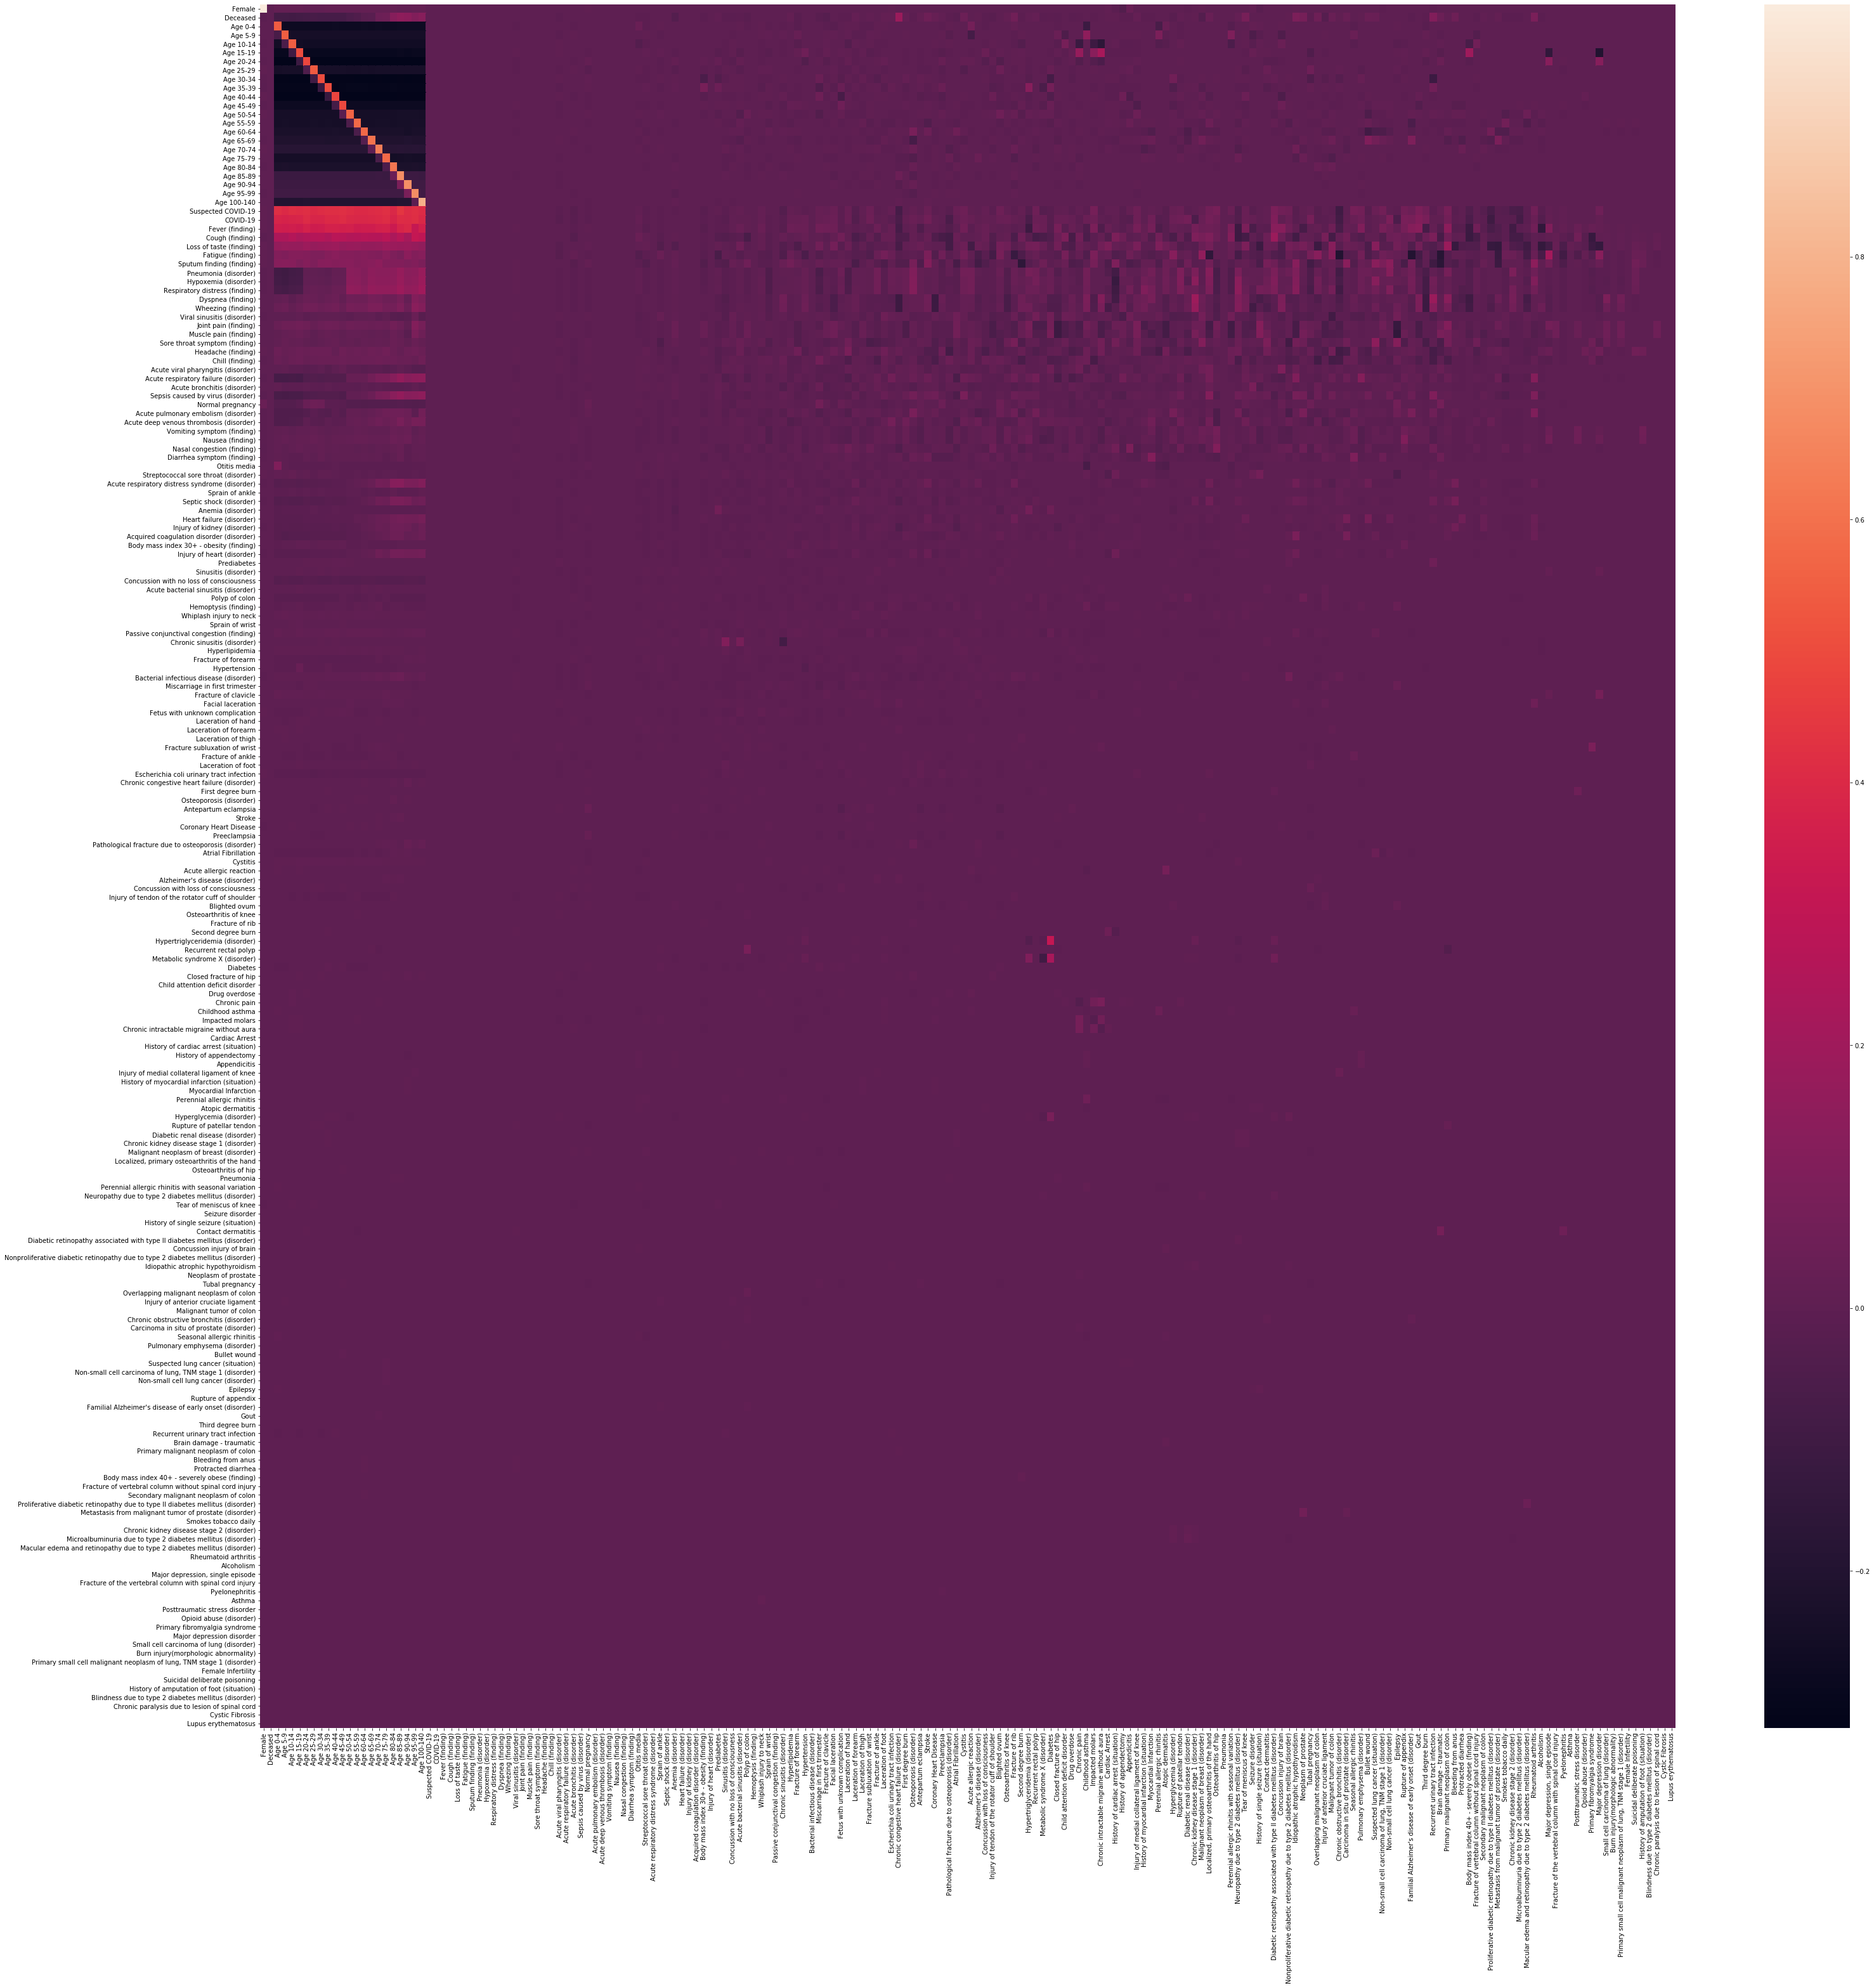

In [44]:
predictConditions.predictConditions(query)